In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import trange, tqdm, notebook

# 1. Исследовательский анализ данных
Загрузка данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
print(labels.info())
labels

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


Формат данных соответствует ожидаемому. Пропуски остутсутствуют. Проверим дубликаты.

In [3]:
labels.duplicated().sum()

0

Дубликатов нет. Посмотрим на распределение возраста.

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


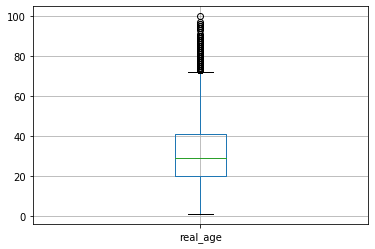

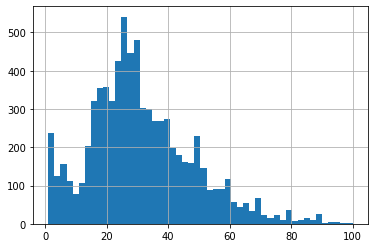

In [4]:
print(labels['real_age'].describe())
labels.boxplot('real_age')
plt.show()
labels['real_age'].hist(bins=50)
plt.show()

Встречаются фотографии для людей в возрасет от 1 года до 100 лет. Больше всего фотографий людей от 20 до 40 лет (средее значение составляет 31 год, медиана 29 лет). Значения выше 75 выходят за рамки усов, но удалять их я бы пока не стал: они релевантны, посмотрим, как справится с ними модель.  
На гистограмме видны периодические выбросы. Рассмотрим их поближе на примере интервала 40-60 лет.

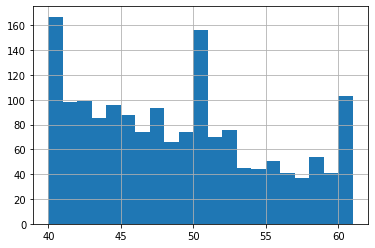

In [5]:
labels['real_age'].hist(bins=21, range=(40,61))
plt.show()

Действительно, присутствуют выбросы на круглых значениях возраста. Как указано в источнике (ChaLearn Looking at People), датасет составлен из нескольких частей, в некоторых из них указан не точный возраст, а возрастная группа. Таким образом, значение "50" может означать и возраст 50 лет, и возрастную группу 45-55 лет. Конечно, это потенциально может снизить точность модели, но разделить эти части невозможно, а удалять данные - слишком расточительно. Пока оставим без изменения и выбросы на круглых значениях.   
Посмотрим несколько фотографий глазами. Заодно выведем возраст и размер картинки.

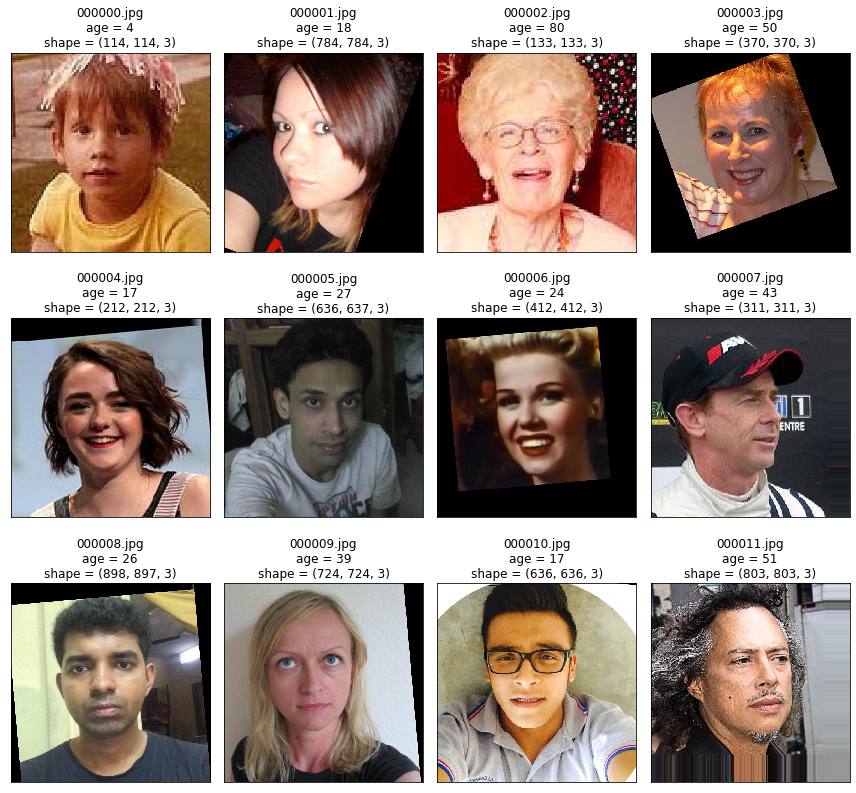

In [6]:
fig = plt.figure(figsize=(12,12))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    
    label = labels.loc[i]
    filename = '/datasets/faces/final_files/' + label['file_name']
    image = Image.open(filename)
    plt.imshow(image)
    
    title = label['file_name']
    title = title + '\nage = ' + str(label['real_age'])
    title = title + '\nshape = ' + str(np.array(image).shape)
    plt.title(title)
    
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Фотографии имеют разный размер, но это будет нивелировано при загрузке фотографий в модель. Нужно будет только определить, к какому размеру привести изображения.  
Видно, что фотографии уже прошли предобработку: они обрезаны по размеру лиц, некоторые из них повернуты таким образом, чтобы лицо было расположено вертикально, размер других увеличен вдоль одной из осей добавлением пикселей, чтобы они стали квадратными. Это важная часть работы с лицами, в данном случае она сделана за нас.  
Чтобы получить более полное представление о фотографиях, определим размер всех, результат добавим в DataFrame.

In [7]:
size_x = []
size_d = []
size_color = []

pbar = notebook.tqdm(total=len(labels))
for name in labels['file_name']:
    pbar.update()
    filename = '/datasets/faces/final_files/' + name
    image = Image.open(filename)
    a_image = np.array(image)
    size_x.append(a_image.shape[0])
    size_d.append(a_image.shape[0] / a_image.shape[1])
    size_color.append(a_image.shape[2])
    
labels['size_x'] = size_x
labels['size_d'] = size_d
labels['size_color'] = size_color

Посмотрим на распределение размера вдоль оси Х

count    7591.000000
mean      464.093927
std       331.289883
min        47.000000
25%       220.000000
50%       384.000000
75%       632.000000
max      4466.000000
Name: size_x, dtype: float64


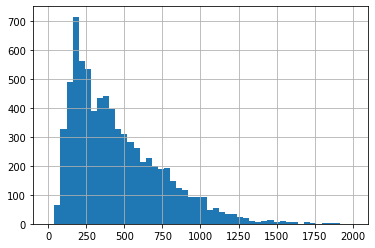

In [8]:
print(labels['size_x'].describe())
labels['size_x'].hist(bins=50, range=(0,2000))
plt.show()

Размер меняется в широких пределах: от 47 до 4466 пикселей, при этом больше всего изображений в диапазоне 150-200 пикселей, затем распределение медленно убывает. Размер 75% изображений не превышает 632 пикселей.  
Теперь посмотрим на соотношение размеров.

In [9]:
labels['size_d'].describe()

count    7591.000000
mean        1.000732
std         0.059985
min         0.335000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.144654
Name: size_d, dtype: float64

Абсолютное большинство изображений квадратные, но присутствует и небольшое число вытянутых. При загрузке таких изображений вместе с квадратными пропорции исказятся, что наверняка приведет к снижению точности. Удалим из выборки те изображения, размер сторон которых отличается больше, чем на 20%.

In [10]:
labels = labels[(labels['size_d']<1.2) & (labels['size_d']>0.8)]
len(labels)

7434

Размер выборки сократился несильно - с 7591 до 7434 изображений.  
Наконец, нужно удостовериться, что все изображения имеют 3 канала.

In [11]:
labels['size_color'].value_counts()

3    7434
Name: size_color, dtype: int64

Все в порядке. Данные подготовлены, можно переходить к обучению модели в GPU-тренажёре.

# 2. Обучение модели

Данные разделим на обучающую и тестовую выборку в соотношении 75:25. Размер изображения возьмем равным 224 на 224, размер батча - 32. Поскольку фотографии уже предобработаны, аугментацию путем поворота и растяжения изображений не будем использовать, только флипы. 
В качестве модели возьмем нейросеть ResNet50 с начальной инициализацией весов от ImageNet, без верхушки, дополненную одним полносвязным слоем с 1 нейроном и активатором ReLu. Функция потерь - MSE (для экономии времени), метрика - MAE (в соответствии с условием задания), оптимайзер - Adam, параметр lr будем подбирать. 

```python
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


# загрузка обучающей выборки
def load_train(path):
    
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(
                                      rescale=1/255.,
                                      validation_split=0.25, 
                                      horizontal_flip=True,
                                      )

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_gen_flow


# загрузка тестовой выборки
def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25)

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_gen_flow


# создание модели
def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    print(model.summary())
    return model


# обучение и проверка модели
def train_model(model, train_data, test_data, epochs=7, 
                steps_per_epoch=None, validation_steps=None):

    features_train, target_train = next(train_data)
    features_test, target_test = next(test_data)
    print('features_train:', len(train_data), features_train.shape)
    print('features_test:', len(test_data), features_test.shape)
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data, 
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model
```

#### Результат

```
2020-07-24 20:34:28.884533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Model: "sequential"
_________________________________________________________________
  Layer (type)                 Output Shape              Param #   
-=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
-=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
None
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
features_train: 178 (32, 224, 224, 3)
features_test: 60 (32, 224, 224, 3)
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/7
2020-07-24 20:34:41.016804: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-07-24 20:34:41.345697: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 46s - loss: 271.5069 - mae: 12.0480 - val_loss: 775.9644 - val_mae: 22.9362
Epoch 2/7
178/178 - 38s - loss: 101.1750 - mae: 7.6102 - val_loss: 808.4940 - val_mae: 23.5153
Epoch 3/7
178/178 - 38s - loss: 79.6696 - mae: 6.7682 - val_loss: 262.1378 - val_mae: 12.0188
Epoch 4/7
178/178 - 38s - loss: 64.4752 - mae: 6.0629 - val_loss: 130.6907 - val_mae: 8.6945
Epoch 5/7
178/178 - 38s - loss: 52.5626 - mae: 5.4973 - val_loss: 84.0054 - val_mae: 6.8413
Epoch 6/7
178/178 - 38s - loss: 44.4538 - mae: 5.0609 - val_loss: 76.1754 - val_mae: 6.6731
Epoch 7/7
178/178 - 38s - loss: 36.5456 - mae: 4.5981 - val_loss: 83.1534 - val_mae: 6.8768
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 83.1534 - mae: 6.8768
Test MAE: 6.8768
```

# 3. Анализ обученной модели

В ходе обучения было установлено, что модель склонна к переобучению: MAE на тестовой выборке зачастую заметно выше, чем на обучающей. Чтобы снизить этот эффект, нужно уменьшать значение параметра lr (скорость обучения). Удовлетворительное значение MAE было полчено при lr=0.0001 на 7 итерациях и составило 6,88. При этом видно, что на шестой итерации был получен результат даже лучше - 6,673. Это означает, что модель успела переобучиться и в этот раз. К сожалению, GPU-тренажёр не позволяет продолжить работу после достижения удовлетворительных результатов, так что сильнее улучшить результат не получилось.

Подозреваю, что такой хороший результат был получен в том числе благодаря тому, что предоставленные нам изображения уже прошли предобработку: обрезаны по размеру лица, повернуты, большинство из них приведено к квадратным.

Рекомендуется продолжить исследование со следующими изменениями: 
- еще сильнее уменьшить lr;
- изменить размер батча;
- изменить размер изображений;
- удалить хвосты (возраст более 80 лет);
- попробовать другие нейросети.